<H1><CENTER> Machine Learning 2 - Tutorial 2 <br /></CENTER></H1>
<H2><CENTER> Author: Sebastian Pineda Arango  <br />
ID: 246098<br />
Universität Hildesheim - Data Analytics Master </CENTER></H2>

<img src="https://www.uni-hildesheim.de/typo3conf/ext/unihildesheim/Resources/Public/Images/logo-uni.svgz" width="100">


## Gaussian process - programming

First we are going to import the libraries and the data used for this tasks:

Printing training data: [[-2.8555]
 [-1.3592]
 [-0.5329]
 [ 0.9785]
 [ 1.4242]
 [-1.9429]
 [ 2.3404]
 [-2.7853]
 [-0.0037]
 [-0.1652]
 [-1.034 ]
 [ 0.7648]]


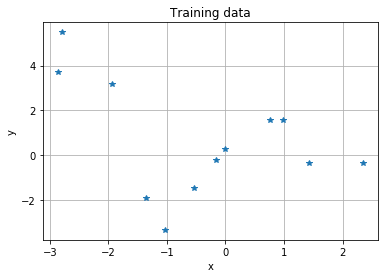

In [2]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix

%matplotlib inline

#Preprocessing the data
with open("tutorial2.dat") as f:
    content = f.readlines()
content = [cont[:-1].split(' ') for cont in content]
content = content[1:]

data = []
for cont in content:
    aux = []
    for c in cont:
        if(c!=""):
            aux.append(float(c))
    data.append(aux)
data = np.array(data)
X = data[:,0].reshape(-1,1)
y = data[:,1]

plt.plot(X,y,'*')
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training data")

print("Printing training data:", X)

We want to implement a Gaussian Process model for one dimensional variable. Gaussian processes are models that use a kernel function to make predictions on new test data. For more information about training set, please refer to *Rasmusen* [1]. In this case, we are going to use a squared exponential kernel, which mathematically has the form:

<center> $k(x, x') = {{\sigma_f}^{2} }  e^{-\frac{1}{2 l^2}{||x-x'||}^{2}}$ 
</center>

**A.**

Now we define a class called *GaussianProcessModel* which implements some interesting methods.

In [3]:
class GaussianProcessModel:
    
    def __init__(self, sigma_f, sigma_y, l):
        
        '''Initialize the model with the given parameters'''
        
        self.sigma_f = sigma_f
        self.sigma_y = sigma_y
        self.l = l
    
    def kernel (self, X):
        
        '''Compute the kernel matrix for all the X'''
        
        d=distance_matrix(X,X, p=2)
        K = (self.sigma_f**2)*(np.exp(-(1/(2*self.l**2))*np.power(d,2)))
        return K

    def fit(self, X,y):
        
        '''Fit the model to the training data'''
        
        N = X.shape[0]
        self.K= self.kernel(X)
        self.K_y = self.K + self.sigma_y*np.eye(N)
        self.alpha = np.linalg.inv(self.K_y)@y
        self.X = X
        
    def predict(self, X_query):
        
        '''Compute the prediction'''
        
        X_query = np.array(X_query)
        n_query = X_query.shape[0]
        X_ = np.vstack(( self.X, X_query))
        K_ = self.kernel(X_)[-n_query:,:-n_query]
        u = K_@self.alpha
        K2 = K_@np.linalg.inv(self.K_y)@K_.T
        K__ = self.kernel(X_)[-n_query:,-n_query:]+ \
           self.sigma_y**2*np.ones((n_query, n_query)) -K2  
     
        return u, K__
    
    def evaluate(self,X,y):
        
        '''Evaluate the current fitted model in terms of the empirical loss'''
        
        loss=0
        for i,xi in enumerate(X):
            u, sigma = self.predict(xi)
            loss += (u[0]-y[i])**2
        return loss

In the above class, for regression, we used the following equations:

<center>$\tilde{\mu_*} = K_*^T (K+\sigma_y^2I)^{-1}y$</center>
<center>$\tilde{\Sigma}_* = K_{**}+\sigma_y^2 I-K_*^T (K+\sigma_y^2)^{-1} K_*$</center>

**B.**

Now let's test the model for $x \in \space [-3,3]$ and with parameters:

<center>$\sigma_f=1, \sigma_y=0.5, l=1$ </center>

The results of the prediciton are also plotted with a confidence interval of 95% ($=2\sigma$).

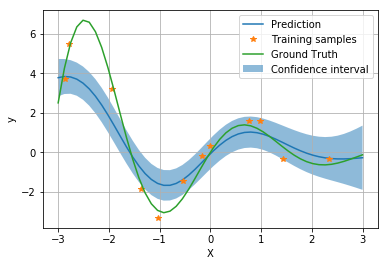

In [4]:
#initializing class
gp = GaussianProcessModel(1,0.5,1)
gp.fit(X,y)

y_list = []
c_list = []
x_list = np.linspace(-3,3)
for x in x_list:
    y_hat, c = gp.predict([x])  #making prediction
    y_list.append(y_hat[0])
    c_list.append(2*c[0][0]) #setting the confidence inteval
    
#formatting output
y_list = np.array(y_list)
c = np.array(c_list)
x_list = np.array(x_list)

#getting the ground truth
y_true = 2*np.sin(2*x_list)*np.exp((-1/2)*x_list)

#plotting results
plt.plot(x_list, y_list)
plt.fill_between( x_list, -c+y_list, c+y_list, alpha=.5)
plt.plot(X,y,'*')
plt.plot(x_list,y_true)
plt.grid()
plt.xlabel("X")
plt.ylabel("y")
plt.legend(("Prediction","Training samples","Ground Truth","Confidence interval"))

We can see that the prediction is very deviated from the ground truth. Therefore, we want to find the best parameters using gradient descend.

** C. ** 

The model does not seem to fit to the trainind data. Tehrefore, now we should optimize the parameters of the model, so that it fits better the training data.

First we conside our model:

<center>$p(y|X)=\mathcal{N}(y|0, K+\sigma_y^2 I)$</center> 

And the log-likelihood is:

<center>$L(l,\sigma_f)=log(p(y|X))$</center>

<center>$\frac{\partial L(l,\sigma_f)}{\partial \theta}=\frac{1}{2}y^T(K+\sigma_y^2 I)^{-1}\frac{\partial K}{\partial \theta}(K+\sigma_y^2 I)^{-1}y+\frac{1}{2}tr((K+\sigma_y^2 I)^{-1}\frac{\partial K}{\partial \theta})$</center>

<center>$\frac{\partial L(l,\sigma_f)}{\partial \theta}=\frac{1}{2}tr((\alpha\alpha^T-(K+\sigma_y^2 I)^{-1})\frac{\partial K}{\partial \theta})$</center>

with $\alpha=(K+\sigma_y^2 I)^{-1}y$

Now we need to find the value of $\frac{\partial K}{\partial \theta}$ for each parameter. We simplify this by finding the value of the derivative for  $\frac{\partial K_{ij}}{\partial \theta}$, where $K_{ij}=k(x_i, x_j)$.
<center>
$\frac{\partial K_{ij}}{\partial l}= \frac{\partial k(x_i, x_j)}{\partial l}= \frac{||x_i-x_j||^2}{l^3}K_{ij}$ </center>


<center>$\frac{\partial K}{\partial l}= \frac{1}{l^3}D\circ K$ 
</center>
Where $D$ is a matrix such as $D_{ij}=||x_i-x_j||^2$ and $\circ$ denotes the Hadamard product.

<center>$\frac{\partial K_{ij}}{\partial \sigma_f}= \frac{\partial k(x_i, x_j)}{\partial l}= 2\sigma_fe^{-\frac{1}{2 l^2}||x_i-x_j||^2}=\frac{2}{\sigma_f}K_{ij}$ </center>
<center>$\frac{\partial K}{\partial l}= \frac{2}{\sigma_f}K$ </center>
<center>$\frac{\partial K}{\partial \sigma_y} = I$</center>

Setting $Z = (\alpha\alpha^T-(K+\sigma_y^2 I)^{-1})$ leads to the following updates equation for the parameters in the gradient ascend algorithm:

<center>$l^{new} = l^{old}+\mu \cdot tr(\frac{1}{l^3}Z(D\circ K))$</center>
<center>$\sigma_f^{new} = \sigma_f^{old}+\mu \cdot tr(\frac{2}{\sigma_f}ZK)$</center>
<center>$\sigma_y^{new} = \sigma_y^{old}+\mu \cdot tr(Z)$</center>

Where $\mu$ is the learning rate.






In [5]:
class GaussianProcessModelTraining (GaussianProcessModel):
    
    def optimize(self, step, maxiter, tol):
        
        '''This function optimizes the parameters for a Gaussian Process
        Model.'''
        
        print("Optimizing...")
        d = np.power(distance_matrix(self.X,self.X, p=2),2)
        N= X.shape[0]

        for i in range(maxiter):

            self.fit(X,y) #recomputing parameters
            z = self.alpha.reshape(-1,1)@self.alpha.reshape(1,-1)- np.linalg.inv(self.K_y)
            
            #gradient of parameter l
            grad_l = (1/(self.l**3))*(np.multiply(self.K,d))
            grad_l =  np.trace(z@grad_l)

            #gradient of parameter sigma_f
            grad_sigma_f = (2/self.sigma_f)*self.K
            grad_sigma_f = np.trace(z@grad_sigma_f)

            #gradient of parameter sigma_y
            grad_sigma_y = np.trace(z)

            #updating parameters
            self.sigma_y = self.sigma_y + step*grad_sigma_y
            self.sigma_f = self.sigma_f + step*grad_sigma_f
            self.l = self.l + step*grad_l
            
            #calculating the madnitud of the gradient
            grad_magnitude = np.sqrt(grad_sigma_y**2 + grad_sigma_f**2 + \
                                     grad_l**2)
            
            #checking tolerance
            if(grad_magnitude < tol):
                break
                
            if(i%20==0):
                print("Iteration ",i)
                print("Loss:",self.evaluate(X,y))
                print("Delta magnitude:", grad_magnitude)

In [6]:
gpt = GaussianProcessModelTraining(1,0.1,1)
gpt.fit(X, y)

#set learning_rate=0.01, maxiterations=5000, tol=0.0001
gpt.optimize(0.01,5000, 0.0001)

Optimizing...
Iteration  0
Loss: 2805.84665334
Delta magnitude: 403.022237035
Iteration  20
Loss: 11.1897647887
Delta magnitude: 1.4142439644
Iteration  40
Loss: 9.86483205344
Delta magnitude: 1.49509138736
Iteration  60
Loss: 8.62089379817
Delta magnitude: 1.60708958759
Iteration  80
Loss: 7.42812852939
Delta magnitude: 1.75245750624
Iteration  100
Loss: 6.24507834078
Delta magnitude: 1.94651116167
Iteration  120
Loss: 5.04135500272
Delta magnitude: 2.21947219808
Iteration  140
Loss: 3.78659205658
Delta magnitude: 2.62443420402
Iteration  160
Loss: 2.4407048478
Delta magnitude: 3.03914894515
Iteration  180
Loss: 1.57471336632
Delta magnitude: 0.395026004675
Iteration  200
Loss: 1.56103907355
Delta magnitude: 0.171543057286
Iteration  220
Loss: 1.5603786291
Delta magnitude: 0.0944038331304
Iteration  240
Loss: 1.56003004469
Delta magnitude: 0.0531474871555
Iteration  260
Loss: 1.55983717246
Delta magnitude: 0.0302929287304
Iteration  280
Loss: 1.55972833174
Delta magnitude: 0.017385919

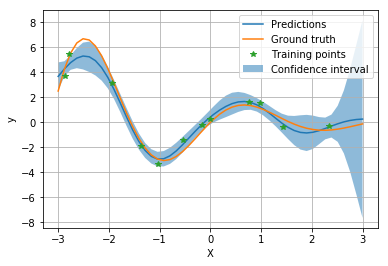

In [7]:
#initializing parameters

gpt.fit(X,y)
y_list = []
c_list = []
x_list = np.linspace(-3,3)

#making predictions for the test interval
for x in x_list:
    y_hat, c = gpt.predict([x])  
    y_list.append(y_hat[0])
    c_list.append(2*c[0][0])

#formatting output
y_list = np.array(y_list)
c = np.array(c_list)

#ground truth
y_true = 2*np.sin(2*x_list)*np.exp((-1/2)*x_list)

#plotting results
plt.plot(x_list, y_list)
plt.plot(x_list, y_true)
plt.fill_between( x_list, -c+y_list, c+y_list, alpha=.5)
plt.plot(X,y,'*')
plt.grid()
plt.xlabel("X")
plt.ylabel("y")
plt.legend(("Predictions","Ground truth", "Training points","Confidence interval"))

Now we can see that the prediction line is closer to the ground turth after optimizing the parameters with gradient ascend. It is interesting to note that for ranges where training samples are very far from each other have a bigger confidence interval. This happens for example for $x > 2.3404$

## Gaussian process II

** A. **


Given a guassian process kernel such as:

<center>$k(x, x') = \sigma_f^2e^{-\frac{1}{2l^2}||x-x'||^2}$</center>

and a training dataset with a single point $(x=0, y=0)$, we have that the kernel matrix looks like:

<center>$K=k(x,x)=k(0,0)=\sigma_f^2$</center>

<center>$K_* =k(x,x_*)=k(0,x_*)=\sigma_f^2e^{\frac{1}{2l^2}||x_*||^2}$</center>

<center>$K_{**}= k(x_*,x_*)=\sigma_f^2$</center>

<center>$\tilde{\Sigma_*} = K_{**}+\sigma_y^2I-K_*^T(K+\sigma_y^2)^{-1}K_*$</center>
 
 For one query point:
 
 <center>$\tilde{\Sigma_*}=\sigma_f^2 + \sigma_y^2 - \sigma_f^2e^{-\frac{1}{2l^2}||x_*||^2}(\sigma_f^2+\sigma_y^2)^{-1}\sigma_f^2e^{-\frac{1}{2l^2}||x_*||^2}$</center>
 
 <center> $\tilde{\Sigma_*}=\sigma_f^2 + \sigma_y^2 - (\sigma_f^2+\sigma_y^2)^{-1}\sigma_f^4e^{-\frac{1}{l^2}||x_*||^2}$ </center>
 
 Also the posterior probability for $(x=0,y=0)$ is given by:
 
  <center> $p(y|X)=\mathcal{N}(y|\mu(x), \Sigma(x))=\mathcal{N}(y|0, \Sigma(0))$</center>

Now, let's implement the idea in Python and see how the covariance invervals change as the parameters do.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#calculating covariance
def cov(x, sigma_f, sigma_y, l):
    c = sigma_f**2+ sigma_y**2 -(sigma_f**4)*((sigma_f**2+sigma_y**2)**(-1))*np.exp(-(l**2)**(-1)*x**2)
    return c

def posterior (x, sigma): 
    out = (1/np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(1/(2*(sigma**2)))*(x**2))
    return out

Text(0,0.5,'p(y)')

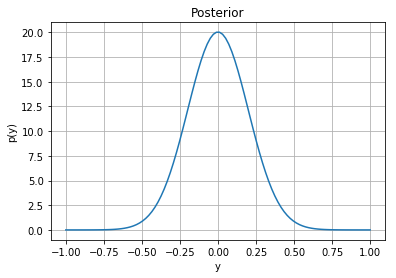

In [113]:
#plotting the posterior
sigma_f = 1
sigma_y = 0.1
l =1
y = np.linspace(-1,1,100)
sigma=cov(0,sigma_f, sigma_y, l )
post = posterior(x, sigma)
plt.plot(y, post)
plt.title("Posterior")
plt.grid()
plt.xlabel("y")
plt.ylabel("p(y)")

** Changing $l$ **

This parameter is called horizontal length scale, and we can see that the greater this parameter is, the less tiled the covariance interval is. It also can be interpreted such as the covariance interval takes more time to reach the maximum value.

Text(0.5,1,'Confidence interval by changing l')

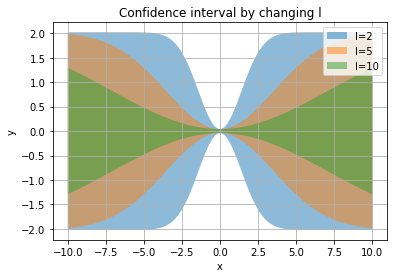

In [83]:
x = np.linspace(-10,10 ,100)

sigma_f = 1
sigma_y = 0.1
l =1

for l_ in [2,5,10]:
    c = 2*cov(x,sigma_f,sigma_y,l_)
    plt.fill_between(x, -c, c, alpha=.5)
plt.grid()
plt.legend(("l=2","l=5","l=10"))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Confidence interval by changing l")

** Changing $\sigma_f$ **

In the following plots, it can be seen that as we increase the value of $\sigma_f$, the final value of the covariance interval (as $x$ appoaches to $\infty$ or $-\infty$) will increase.

Text(0.5,1,'Changing sigma_f')

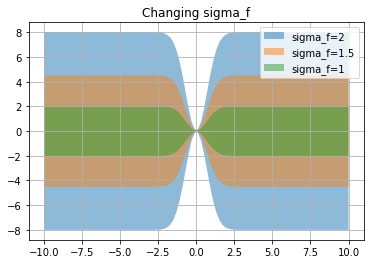

In [15]:
#changing sigma_f
for sigma_f_ in [2,1.5,1]:
    c = 2*cov(x,sigma_f_,sigma_y,l)
    plt.fill_between(x, -c, c, alpha=.5)
plt.grid()
plt.legend(("sigma_f=2","sigma_f=1.5","sigma_f=1"))
plt.title("Confidence interval by changing sigma_f")

** Changing $\sigma_y$ ** 

After having a look to the following plots, it is possible to see that as we increase $\sigma_y$, the confidence interval increases in general (even for the around the training samples). 

Text(0.5,1,'Changing sigma_y')

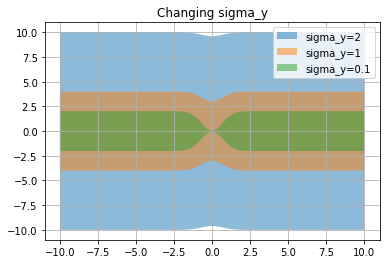

In [16]:
#changing sigma_y
for sigma_y_ in [2,1,0.1]:
    c = 2*cov(x,sigma_f,sigma_y_,l)
    plt.fill_between(x, -c, c, alpha=.5)
plt.grid()
plt.legend(("sigma_y=2","sigma_y=1","sigma_y=0.1"))
plt.title("Confidence interval by changing sigma_y")

** B.**

Firstly, we know that:

 <center> $\tilde{\Sigma_*}=\sigma_f^2 + \sigma_y^2 - (\sigma_f^2+\sigma_y^2)^{-1}\sigma_f^4e^{-\frac{1}{l^2}||x_*||^2}$ </center>
 
 Given that $x=x_*$ and $x=0$, therefore $x_*=0$. Then, if $x=x_*$ we have:
 
  <center> $\tilde{\Sigma_*}=\sigma_f^2 + \sigma_y^2 - (\sigma_f^2+\sigma_y^2)^{-1}\sigma_f^4e^{-\frac{1}{l^2}||0||^2}$ </center> 
 <center> $= \sigma_f^2 + \sigma_y^2 - (\sigma_f^2+\sigma_y^2)^{-1}\sigma_f^4$ </center>

Thus, we conclude that when $x_*=x$, $l$ does not influence the value (it only depends on $\sigma_f$ and $\sigma_y$), which matches the graphical interpretation in the last section.

If we consider that $|x-x_*| \rightarrow \infty$, then:

  <center> $\tilde{\Sigma_*}=\sigma_f^2 + \sigma_y^2 - (\sigma_f^2+\sigma_y^2)^{-1}\sigma_f^4e^{-\frac{1}{l^2}||\infty||^2}$</center>  <center>$= \sigma_f^2 + \sigma_y^2$</center>
  
This also indicates that the final value of the covariance (as $x$ approaches to infinite) is only depending on $\sigma_f$ and $\sigma_y$. This also marches the previous results (in section A).

### References
[1] Carl Edward Rasmussen and Christopher K. I. Williams. 2005. *Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning)*. The MIT Press